In [37]:
from covid.simulator import Population
from covid.auxilliary import symptom_names
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from covid.policy import Policy
from scipy.stats import beta, bernoulli, uniform

In [38]:
class ThompsonSampling:
    def __init__(self, nvacc):
        # Priors for the beta-bernoulli model
        self.a = np.ones(nvacc) # uniform prior
        self.b = np.ones(nvacc) # uniform prior
        self.nvacc = nvacc

    def update(self, action, outcome):
        self.a[action] += outcome
        self.b[action] += 1 - outcome

    def get_params(self):
        # Returns the parameters of all the beta distrobutions.
        return self.a, self.b

    def get_prob(self):
        return beta.rvs(self.a, self.b)

In [39]:
class Naive(Policy):
    def set_model(self, model):
        self.model = model
    
    def get_action(self):
        probs = self.model.get_prob()
        
        #print(probs)
        ret_val = np.argmin(probs)
        #print(ret_val)
        #print(ret_val)
        return ret_val

    def observe(self, action, outcome):
        self.model.update(action, outcome)
        

In [4]:
#thetas = np.array([0.6, 0.55, 0.5])

In [5]:
n_genes = 128
n_vaccines = 3
n_treatment = 4
#population = Population(n_genes, n_vaccines, n_treatment)
N = 10000
#X = population.generate(N)

In [63]:
policy = Naive(n_actions=3, action_set=[0, 1, 2])
model = ThompsonSampling(nvacc=3)
policy.set_model(model)

action_arr = np.zeros(N)
symptom_arr = np.zeros(N)

for i in range(N):
    action = policy.get_action()
    #print(thetas[action])
    reward = bernoulli.rvs(thetas[action])
    print(reward)
    policy.observe(action, reward)
    action_arr[i] = action
    symptom_arr[i] = reward

    #print(action, reward)
    #policy.observe(action, reward)
    #print(action)

alphas, betas = policy.model.get_params()
for i, j in zip(alphas, betas):
    print(i,j)
print(alphas[0]/(alphas[0] + betas[0]))
print(alphas[1]/(alphas[1] + betas[1]))
print(alphas[2]/(alphas[2] + betas[2]))


Initialising policy with  3 actions
A = { [0, 1, 2] }
0
0
0
1
1
1
0
1
1
1
1
1
1
1
0
1
0
0
0
1
0
0
0
0
0
0
1
1
1
0
1
1
1
0
0
1
0
0
1
1
0
0
1
0
1
1
0
0
1
1
0
1
1
0
1
1
0
1
0
1
1
1
0
1
0
1
0
0
0
1
0
1
0
0
0
1
1
0
0
0
1
0
1
0
0
1
0
0
1
0
1
1
1
0
0
0
0
0
1
0
1
1
0
1
0
0
0
1
0
0
1
0
1
1
1
1
0
0
0
0
0
0
0
1
1
0
0
1
1
0
1
0
1
0
1
0
0
0
1
0
1
1
0
0
1
1
1
1
1
0
1
1
1
0
0
1
1
0
1
1
0
0
1
0
1
0
0
1
1
1
0
0
1
0
1
0
0
1
0
1
1
1
1
0
1
0
0
0
1
0
0
1
1
1
1
0
0
0
0
1
1
0
0
0
1
1
1
0
0
1
0
1
0
0
0
0
0
0
1
0
1
0
1
1
1
1
1
1
0
1
1
1
1
0
0
0
0
0
0
0
0
1
1
0
1
1
0
0
1
0
0
0
1
1
0
1
0
1
0
0
1
1
1
0
0
1
0
1
1
0
0
0
1
1
0
1
1
0
1
1
1
1
0
0
1
0
1
0
0
0
0
0
1
0
0
1
0
0
0
1
0
0
1
0
1
1
1
1
0
1
1
0
0
1
1
0
0
1
1
1
1
0
0
0
0
0
0
0
1
1
1
0
1
0
0
0
1
1
0
1
0
0
1
0
0
0
1
1
0
1
0
0
1
0
1
0
1
1
1
0
0
0
1
1
0
0
1
0
0
0
0
1
0
0
1
1
1
0
0
1
1
0
0
1
1
0
1
1
1
0
0
0
0
0
0
1
0
1
0
0
0
1
1
0
0
0
1
1
1
0
0
1
0
0
0
0
0
1
1
1
1
1
0
1
1
0
0
0
1
0
1
1
1
1
0
0
1
1
1
1
1
0
1
1
0
0
1
1
1
0
0
1
1
1
1
0
0
1
0
0
0
1
0
0
0
1
1
0
0
0
0
1
0


1
1
0
0
1
1
0
1
1
0
1
0
0
0
1
0
0
0
0
1
0
1
1
0
1
0
1
1
0
0
0
1
1
0
0
1
1
0
1
0
0
0
1
1
0
0
1
1
0
0
0
1
1
1
0
1
1
0
0
1
0
0
0
1
1
1
1
1
0
1
0
0
0
1
0
1
1
1
1
1
0
0
1
0
0
1
0
0
0
1
1
0
0
0
0
1
1
1
0
1
0
1
1
0
1
1
0
0
1
0
0
1
0
1
1
1
1
0
0
1
0
1
0
1
0
1
1
1
1
1
1
1
1
0
0
0
0
0
0
1
1
1
0
0
1
1
0
0
1
1
0
0
0
1
0
1
1
0
0
0
0
0
0
0
0
0
1
1
0
0
0
1
0
1
1
0
0
0
0
1
1
1
1
1
1
0
1
0
0
1
1
0
0
1
1
1
1
0
0
0
0
1
1
0
1
0
0
1
0
0
1
1
0
1
0
0
0
1
1
1
0
0
1
0
1
0
1
0
1
0
0
1
0
1
0
1
1
1
1
0
0
0
0
1
0
0
0
0
1
1
1
1
1
0
0
0
0
1
1
0
0
1
1
1
0
0
0
0
0
0
0
0
0
1
1
1
0
1
0
0
0
0
1
1
1
1
1
0
0
0
1
1
0
1
0
0
1
1
0
1
1
1
1
0
0
1
1
1
1
1
0
1
1
0
1
1
0
1
1
1
1
0
1
0
0
0
1
1
1
0
1
0
1
1
1
1
0
0
0
1
0
1
0
1
1
1
1
0
1
0
1
0
0
1
1
1
0
1
1
0
0
0
1
0
1
0
0
0
0
1
1
1
1
1
0
1
1
0
1
1
0
1
0
1
0
1
1
1
0
1
1
1
1
0
0
1
1
1
1
1
0
0
1
0
0
0
1
1
0
0
1
0
0
1
1
0
0
1
0
1
0
0
1
1
1
1
1
0
0
0
1
1
0
0
0
1
0
0
1
1
0
1
1
0
0
1
1
0
1
1
0
1
1
1
1
1
1
0
1
1
1
1
0
0
1
0
0
0
0
1
1
0
1
1
0
0
0
0
0
1
0
0
1
0
0
1
1
0
1
1
1
1
1
0
0
0
0
1
0
1


1
1
1
1
1
0
1
1
1
1
0
1
1
1
0
0
0
1
1
0
0
1
0
0
1
0
0
1
0
1
1
0
0
0
1
1
0
1
0
1
1
0
1
1
1
1
1
0
1
1
1
0
1
0
1
1
0
1
1
1
0
0
1
0
1
0
0
0
1
1
0
1
0
0
0
1
0
0
1
0
0
0
1
1
0
0
1
1
1
0
0
0
0
1
1
0
1
1
1
0
1
0
1
1
1
0
1
0
0
0
1
0
0
0
1
0
0
1
1
1
1
0
1
0
0
0
1
1
1
0
0
1
1
1
1
1
0
1
0
1
0
0
0
0
0
1
1
1
0
0
1
0
1
0
1
0
0
1
0
0
0
1
1
1
1
1
0
0
1
1
0
1
1
1
1
1
0
1
1
1
1
1
0
1
0
1
1
1
1
1
1
1
0
0
1
1
1
0
1
0
0
1
0
0
0
1
1
0
0
1
1
0
1
0
1
1
1
1
0
1
1
1
0
1
0
1
0
1
1
1
1
0
0
1
0
1
1
1
1
0
1
0
1
0
0
1
1
0
1
0
0
1
1
0
0
1
0
0
0
0
0
0
0
0
1
1
0
0
1
0
1
0
0
1
0
0
0
1
0
0
1
1
0
1
0
0
1
1
0
1
0
0
0
1
1
1
0
1
1
1
0
0
0
1
0
0
1
0
0
1
1
0
0
1
0
1
0
1
0
0
0
0
1
1
0
0
0
0
0
0
0
0
1
0
1
1
1
0
1
1
1
1
0
1
1
0
0
1
0
0
0
0
1
0
0
0
1
0
1
0
1
0
0
0
0
0
1
1
0
1
0
1
1
1
1
1
1
0
1
0
1
0
0
0
0
0
1
0
1
0
0
0
1
1
0
1
0
1
0
0
1
1
0
1
1
0
0
1
0
1
1
0
1
1
0
1
1
1
1
0
0
0
1
1
0
1
0
0
0
1
0
0
1
1
1
1
1
1
0
1
1
0
0
0
0
1
0
0
1
0
1
1
1
1
1
0
1
1
1
0
1
1
0
1
1
0
1
1
0
0
0
0
1
1
1
1
0
1
1
1
0
1
0
1
0
1
0
1
0
0
1
1
0
1
0
1
0
0
1
0


(array([ 155.,    0.,    0.,    0.,    0.,  405.,    0.,    0.,    0.,
        9440.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

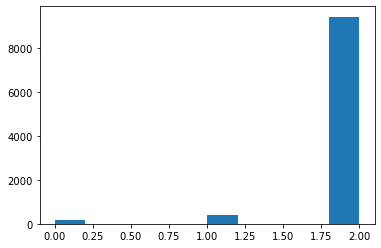

In [64]:
#print(action_arr)
#plt.scatter(range(N), action_arr)
plt.hist(action_arr)

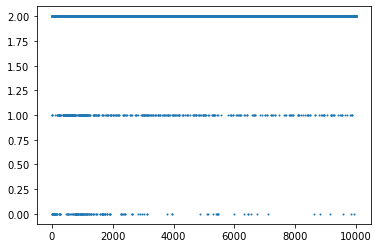

In [65]:
plt.scatter(range(N), action_arr, s=1)

In [108]:
n_genes = 128
n_vaccines = 3 # DO NOT CHANGE, breaks the simulator.
n_treatments = 4
n_population = 10_000
n_symptoms = 10

# symptom names for easy reference
from covid.auxilliary import symptom_names

population = Population(n_genes, n_vaccines, n_treatments)
X = population.generate(n_population)
n_features = X.shape[1]

In [109]:
#new_col = X[:,[5,7,8]].sum(axis=1)
#new_col0 = new_col > 0
#new_col01 = new_col0.astype(int)
#new_col01 = np.reshape(new_col01,(n_population,-1))
#X_new = np.hstack((X,new_col01))



In [110]:
action_space = np.array([-1,0,1,2])
n_actions = action_space.shape[0]

In [111]:
policy = Naive(n_actions, action_space)
model = ThompsonSampling(n_actions)
policy.set_model(model)



Initialising policy with  4 actions
A = { [-1  0  1  2] }


In [112]:
action_arr = np.zeros(n_population)
symptom_arr = np.zeros((n_population, n_symptoms+1))
symptom_arr.shape

(10000, 11)

In [125]:
print("With a for loop")
# The simplest way to work is to go through every individual in the population
for t in range(n_population):
    a_t = policy.get_action()
    #print(type(a_t))
    #a_t = np.int(3)
    # Then you can obtain results for everybody
    y_t = population.vaccinate([t], a_t.reshape((1, 1)))
    #print(y_t.shape)
    new_col = y_t[:,[5,7,8]].sum(axis=1)
    
    #print(y_t)
    new_col0 = new_col > 0
    new_col01 = new_col0.astype(int)
    
    #new_col01 = np.reshape(new_col01,(n_population,-1))
    
    new_col01 = np.reshape(new_col01,(1,-1))
    y_t_new = np.hstack((y_t,new_col01))
    
    # Feed the results back in your policy. This allows you to fit the
    # statistical model you have.
    #print( y_t_new[:,10])
    
    policy.observe(a_t, y_t_new[:,10])
    #policy.observe(a_t, y_t_new[:,1])
    
    action_arr[t] = a_t
    symptom_arr[t] = y_t_new


With a for loop


In [126]:
print(action_arr)

[3. 1. 1. ... 3. 0. 1.]


In [127]:
alphas, betas = policy.model.get_params()
for i, j in zip(alphas, betas):
    print(i,j)
print(alphas[0]/(alphas[0] + betas[0]))
print(alphas[1]/(alphas[1] + betas[1]))
print(alphas[2]/(alphas[2] + betas[2]))

181.0 3998.0
495.0 11390.0
37.0 590.0
551.0 12766.0
0.0433117970806413
0.041649137568363484
0.05901116427432217


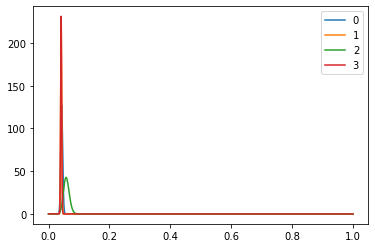

In [128]:
xs = np.linspace(0, 1, 10000)
plt.plot(xs, beta.pdf(xs, alphas[0], betas[0]))
plt.plot(xs, beta.pdf(xs, alphas[1], betas[1]))
plt.plot(xs, beta.pdf(xs, alphas[2], betas[2]))
plt.plot(xs, beta.pdf(xs, alphas[3], betas[3]))
plt.legend(['0', '1', '2', '3'])

#


(array([1027.,    0.,    0., 3786.,    0.,    0.,  125.,    0.,    0.,
        5062.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

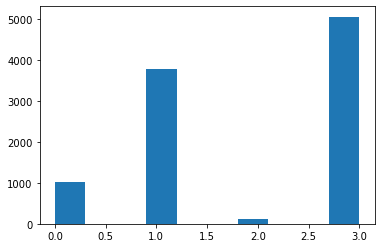

In [129]:
plt.hist(action_arr)

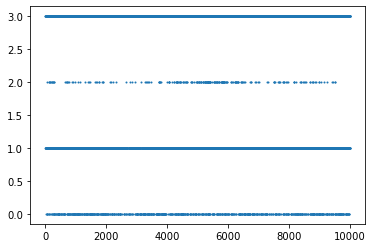

In [124]:
plt.scatter(range(n_population), action_arr, s=1)

In [134]:
print(action_arr.shape)

def plot_fair_pol(actions, data):
    mm = np.where(data[:,11]==1) #male
    ff = np.where(data[:,11]==0) #female

    m_a = np.take(actions, mm)
    m_a = m_a.flatten()

    f_a = np.take(actions, ff)
    f_a = f_a.flatten()

    plt.hist([m_a, f_a],label=['male','female'])
    plt.xlabel('Vaccine')
    plt.ylabel('Frequency')
    plt.title('Vaccines per gender after policy')
    plt.legend(loc='upper right')
    plt.savefig('figures/fair_policy_plot.png')
    plt.show()



(10000,)


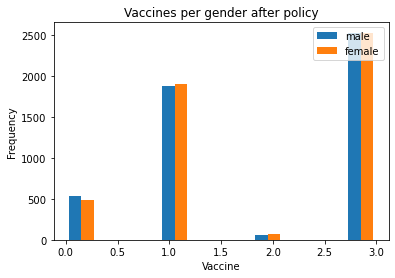

In [133]:
plot_fair_pol(action_arr, X)